In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# loads the dataframes
semi_leptonic_df = pd.read_hdf('/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/TTToSemiLeptonic/df_ml_inputs.hd5')
higgs_df = pd.read_hdf('/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/ttH125/df_ml_inputs.hd5')

# labels signal vs background
semi_leptonic_df['signal'] = 0
higgs_df['signal'] = 1

# combines the dataframes and randomly shuffles the rows
full_df = semi_leptonic_df.append(higgs_df, ignore_index=True)
full_df = shuffle(full_df)

In [2]:
# removes unnecessary columns
useful_cols = ['BiasedDPhi',
               'DiJet_mass',
               'HT', 
               'InputMet_InputJet_mindPhi',
               'InputMet_pt', 
               'MHT_pt',
               'MinChi',
               'MinOmegaHat',
               'MinOmegaTilde',
               'ncleanedBJet', 
               'ncleanedJet', 
               'signal',]

df = full_df[useful_cols]

# creates some new features for the NN
df['totalJets'] = df['ncleanedJet'] + df['ncleanedBJet']
df['totalJetMass'] = full_df['cleanedJet_mass'].apply(lambda x: sum(x))
df['totalJetArea'] = full_df['cleanedJet_area'].apply(lambda x: sum(x))
df['totalJet_pt'] = full_df['cleanedJet_pt'].apply(lambda x: sum(x)) # seems to contradict HT most of the time

# splits data into training and validation
X, y = df.drop('signal', axis=1, ), df['signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

print('Removed Columns:', [col for col in full_df.columns if col not in useful_cols])
print('Included Columns:', list(X.columns))

columns = X.columns
X_train.head()

Removed Columns: ['dataset', 'entry', 'InputMet_phi', 'MHT_phi', 'cleanedJet_area', 'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta', 'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi', 'cleanedJet_pt', 'hashed_filename', 'weight_nominal', 'xs_weight']
Included Columns: ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi', 'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'ncleanedBJet', 'ncleanedJet', 'totalJets', 'totalJetMass', 'totalJetArea', 'totalJet_pt']


,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,totalJets,totalJetMass,totalJetArea,totalJet_pt
355856,-2.922184,153.759471,391.534546,2.871094,377.250,385.426514,1.570796,1.101805,0.778095,0,3,3,57.621094,1.296631,391.534565
215776,-1.734131,150.685180,567.941284,0.914062,236.500,263.674957,0.742368,0.742369,0.525959,1,8,9,80.757812,4.199219,567.941259
63721,-2.696405,82.328448,339.755188,1.264648,269.750,248.516815,1.354708,0.915050,0.313265,0,3,3,44.132812,1.506104,339.755203
281788,1.917001,149.809010,259.439453,2.218750,214.500,213.705719,1.570796,0.955813,0.623146,2,2,4,29.468750,1.037598,259.439453
273203,-1.479079,162.833108,630.671875,2.019531,208.125,230.245361,0.750845,0.750845,0.750845,0,6,6,81.750000,2.942139,630.671890


In [3]:
from sklearn.preprocessing import StandardScaler
import math

scaler = StandardScaler()

# takes the log of each column to remove the skewness in the distributions
def remove_skewness(df):
    # BiasedDPhi has negative values so needs to be shifted
    df['BiasedDPhi'] += math.pi

    for col_name in X_train.columns:
        if col_name not in ['ncleanedBJet', 'ncleanedJet', 'totalJets', 'totalJetArea', 'BiasedDPhi']:
            df[col_name] = np.log(df[col_name])


remove_skewness(X_train)
remove_skewness(X_test)

# scales features so they all have the same mean and variance
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

X_train.head()

,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,totalJets,totalJetMass,totalJetArea,totalJet_pt
0,-0.657307,-0.050917,-0.152304,1.353694,1.580262,1.743097,0.821554,0.784112,0.750720,-0.918209,-0.832831,-0.990925,0.016444,-1.049037,-0.152304
1,0.252207,-0.079705,0.740575,-0.966265,-0.524062,0.018778,-1.745912,-1.195990,-0.419294,0.312753,2.079862,1.741926,0.776867,2.421502,0.740575
2,-0.484462,-0.941323,-0.492822,-0.308211,0.068748,-0.250141,0.314576,-0.147250,-1.967387,-0.918209,-0.832831,-0.990925,-0.584309,-0.798577,-0.492821
3,3.047333,-0.088017,-1.140261,0.831246,-0.964062,-0.935588,0.821554,0.071308,0.087272,1.543716,-1.415369,-0.535450,-1.494101,-1.358755,-1.140260
4,0.447463,0.030810,0.992078,0.640553,-1.100025,-0.596996,-1.707017,-1.139058,0.644213,-0.918209,0.914785,0.375500,0.804375,0.918448,0.992078


In [19]:
# sets hyperparameters
learning_rate_init = 0.05 # 0.001
activation='tanh'
n_iter_no_change = 10

In [15]:
from xgboost import XGBClassifier

# XGBoost Classifier
bdt = XGBClassifier(n_estimators=2000,
        learning_rate=learning_rate_init, 
        nthread=-1,
        random_state=1,
        max_depth=6,
        scale_pos_weight=3)

bdt.fit(X_train, y_train,
        early_stopping_rounds=n_iter_no_change,
        eval_set=[(X_test, y_test)],
        verbose=True,)

[17:31:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.69312
[1]	validation_0-logloss:0.69310
[2]	validation_0-logloss:0.69306
[3]	validation_0-logloss:0.69305
[4]	validation_0-logloss:0.69301
[5]	validation_0-logloss:0.69298
[6]	validation_0-logloss:0.69296
[7]	validation_0-logloss:0.69293
[8]	validation_0-logloss:0.69290
[9]	validation_0-logloss:0.69288
[10]	validation_0-logloss:0.69285
[11]	validation_0-logloss:0.69282
[12]	validation_0-logloss:0.69279
[13]	validation_0-logloss:0.69277
[14]	validation_0-logloss:0.69274
[15]	validation_0-logloss:0.69271
[16]	validation_0-logloss:0.69268
[17]	validation_0-logloss:0.69266
[18]	validation_0-logloss:0.69263
[19]	validation_0-logloss:0.69260
[20]	validation_0-logloss:0.69258
[21]	validation_0-logloss:0.69255
[22]	valid

In [18]:
# saves the model
bdt.save_model('xgb.json')

In [ ]:
# loads the model
bdt = xgb.Booster()  # init model
bdt.load_model('xgb.json')  # load data

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     74057
           1       0.65      0.39      0.49     24826

    accuracy                           0.79     98883
   macro avg       0.74      0.66      0.68     98883
weighted avg       0.78      0.79      0.77     98883

Background Events Detected (True Negatives):  68948
Background Events Incorrectly Detected (False Positives):  5109
Signals Missed (False Negatives):  15202
Signals Detected (True Positives):  9624
Total Signals:  24826


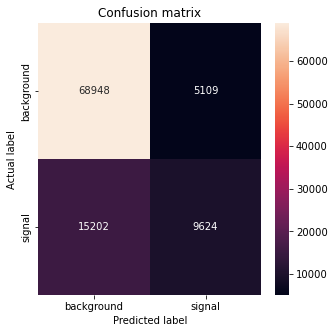

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

preds = bdt.predict(X_test)
print(classification_report(y_test, preds))
print('score:', bdt.score(X_test, y_test), '\n')

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=['background', 'signal'], yticklabels=['background', 'signal'])

  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Background Events Detected (True Negatives): ', cm[0][0])
  print('Background Events Incorrectly Detected (False Positives): ', cm[0][1])
  print('Signals Missed (False Negatives): ', cm[1][0])
  print('Signals Detected (True Positives): ', cm[1][1])
  print('Total Signals: ', np.sum(cm[1]))

plot_cm(y_test, preds)

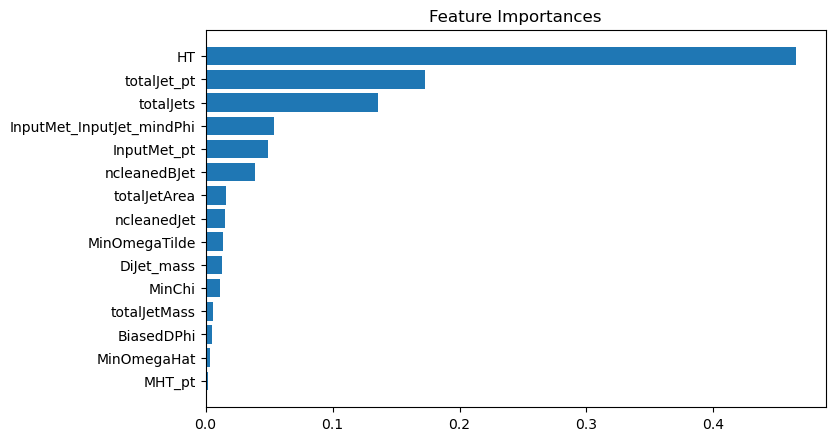

In [17]:
def plot_scores(scores, title):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title(title)

# Plots the XGBoost Feature Importances
importances = bdt.feature_importances_
importances = pd.Series(importances, index=X.columns)

plt.figure(dpi=100, figsize=(8, 5))
plot_scores(importances, "Feature Importances")

In [12]:
from sklearn.feature_selection import mutual_info_classif

# calculates mutual information score for each feature
discrete_features = (X.dtypes == int)
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Score", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# calculates correlations with signal for each feature
corrmat = df.corr()
corr = corrmat[['signal']].sort_values(by=['signal'], ascending=False, key=abs)

# combines correlations, mutual information scores and feature importances into one df
feature_df = pd.concat([corr, mi_scores, importances], sort=False, axis=1).drop('signal')
feature_df = feature_df.rename(columns={"signal": "Signal Correlation", 0: "XGBoost Importance"})
feature_df

KeyboardInterrupt: 